In [2]:
# used for data augmentation
!pip install -U git+https://github.com/albumentations-team/albumentations
# timm pytorch image model
!pip instal timm
# all modules (main and contrib)
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-yq48r19v
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-yq48r19v
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125709 sha256=dfa81cce1f156e46432558b1d49a18b692301a2ebf1848a5d8b082e1a005a7a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-_9b9n8w5/wheels/6d/72/93/d30af2a1f90e7c7e811e8fa43aa723971c91af45052ffa1b5a
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
E

In [3]:
!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 3.89 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
import sys
sys.path.append('/content/object-localization-dataset')

In [6]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

## Preprocessing

In [7]:
train = pd.read_csv(CSV_FILE)
train

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


In [8]:
from google.colab.patches import cv2_imshow

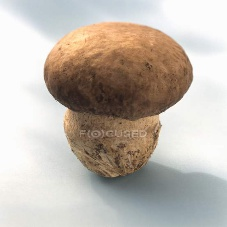

In [9]:
row = train.iloc[185]
img = cv2.imread(DATA_DIR + row['img_path'])
cv2_imshow(img)

In [10]:
#BGR is a default format when loading a picture
# application uses RGB
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [11]:
# Define the top-left and bottom-right corners of the rectangle
pt1 = (row['xmin'],row['ymin'])
pt2 = (row['xmax'],row['ymax'])

In [12]:
# img , (top left),(bottom right), (color of rectangle (default BGR) we have converted to RGB), (thickness)
bnd_box = cv2.rectangle(img,pt1,pt2,(255,0,0),2)

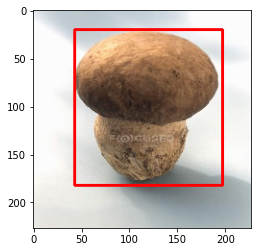

In [13]:
plt.imshow(img)

In [14]:
train_df, valid_df = train_test_split(train, test_size = 0.2, random_state = 42)

In [15]:
print(train_df.shape)
print(valid_df.shape)
print(train.shape)

(148, 8)
(38, 8)
(186, 8)


## Augmentation

we have only 185 data which is very low we need to augemnt some data.

In [16]:
import albumentations as A
IMG_SIZE = 140

In [17]:
# first parameter applies to train (horizontalflip and verticalflip with prob of 0.5)
# second parameter applies to bounding box (Specifies the bounding box format of the dataset, Specifies the label field to be used in the data to identify the class/label of the object in each bounding box.)
train_augs = A.Compose(
    [A.Resize(IMG_SIZE,IMG_SIZE),A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),A.Rotate()],
    bbox_params = A.BboxParams(format='pascal_voc',label_fields=['class_labels'])
)

In [18]:
valid_augs = A.Compose(
    [A.Resize(IMG_SIZE,IMG_SIZE)], 
    bbox_params = A.BboxParams(format='pascal_voc',label_fields=['class_labels'])
)

## Custom Dataset

In [19]:
class ObjectDataset(torch.utils.data.Dataset):

  def __init__(self,df,augmentation):
    self.df = df
    self.augmentation = augmentation

  def __len__(self):
    return len(self.df)

  def __getitem__(self,index):
    row = self.df.iloc[index]

    bbox = [[row.xmin,row.ymin,row.xmax,row.ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentation:
      data = self.augmentation(image = img, bboxes = bbox, class_labels = [None]) # only localize => don't need class_labels
      img = data['image']
      bbox = data['bboxes'][0] # [[xmin,ymin,xmax,ymax]]
    # move the channel dimension from 2nd position to 0th position as Torch tensor expects channels to appear first
    img = torch.from_numpy(img).permute(2,0,1)
    bbox = torch.Tensor(bbox)

    return img,bbox

In [20]:
trainset = ObjectDataset(train_df,train_augs)
validset = ObjectDataset(valid_df,valid_augs)

In [21]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the validset: {len(validset)}")

Total examples in the trainset: 148
Total examples in the validset: 38


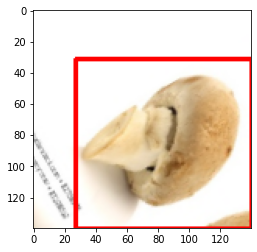

In [22]:
img, bbox = trainset[100]
xmin, ymin, xmax, ymax = bbox
pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))
bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(), pt1, pt2, (255,0,0), 2)  # cv2 use np instead of tensor
plt.imshow(bnd_img)

In [23]:
BATCH_SIZE = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset,batch_size = BATCH_SIZE,shuffle=True)

In [24]:
print(f'number of train batches: {len(trainloader)}')
print(f'number of validation batches: {len(validloader)}')

number of train batches: 10
number of validation batches: 3


In [25]:
for i,(img,bbox) in enumerate(trainloader):
  print(f'a batch for images: {img.shape}')
  print(f'a batch for bboxes: {bbox.shape}')
  break;
# first is batch size, channel, height,weight
# first is batch size , 4 is size of bounding box (x_min, y_min, x_max, y_max)

a batch for images: torch.Size([16, 3, 140, 140])
a batch for bboxes: torch.Size([16, 4])


## Model

In [26]:
from torch import nn
!pip install timm
import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.6 MB/s eta 0:00:00


In [27]:
timm.models.list_models() 

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw

See the explaination of EfficientNet [here](https://medium.com/mlearning-ai/understanding-efficientnet-the-most-powerful-cnn-architecture-eaeb40386fad).

In [28]:
# we are going to use efficient models since we are limited by compute power and memory such as EfficientNet, MobileNetV3, and RegNet.
timm.list_models('*efficient*')

['efficientformer_l1',
 'efficientformer_l3',
 'efficientformer_l7',
 'efficientnet_b0',
 'efficientnet_b0_g8_gn',
 'efficientnet_b0_g16_evos',
 'efficientnet_b0_gn',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_g8_gn',
 'efficientnet_b3_gn',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'efficientnetv2_s',
 'efficientnetv2_xl',
 'gc_efficientnet

In [29]:
MODEL_NAME = 'efficientnet_b0'
class ObjectModel(nn.Module):
  def __init__(self):
    super(ObjectModel,self).__init__()
    self.backbone = timm.create_model(MODEL_NAME,pretrained=True,num_classes=4) #output without softmax
  def forward(self, images, gt_bboxes= None):
    bboxes = self.backbone(images)
    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes,gt_bboxes)
      return bboxes,loss
    return bboxes

In [30]:
model = ObjectModel()
device = 'cuda'
model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


ObjectModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

In [ ]:
rando,